In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
import random
from keras.callbacks import ReduceLROnPlateau

In [2]:
# Переменную окружения выставить ДО импорта numpy и sklearn
# Количество использованных ядер = n_jobs * OPENBLAS_NUM_THREADS
# Поэтому, если используете n_jobs > 1, то, пожалуйста, ставьте OPENBLAS_NUM_THREADS = 1
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [5]:
train_df = pd.read_csv('MNIST/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('MNIST/sign_mnist_test/sign_mnist_test.csv')

In [6]:
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')

In [7]:
train_df.shape

(27455, 785)

In [9]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [6]:
test_data.shape

(7172, 785)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

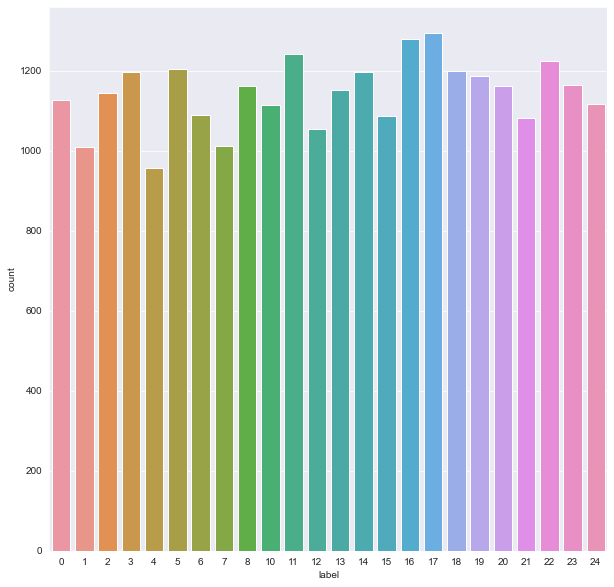

In [7]:
import seaborn as sns
plt.figure(figsize = (10, 10))
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [8]:
# scale X values
X_train = train_data[:, 1:] /255.
X_test = test_data[:, 1:] /255.

# tensor for neural network
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

#Convert y to categorical
y_train = train_data[:, 0]
y_train_cat = to_categorical(y_train, num_classes = 25)
y_test = test_data[:,0]
y_test_cat = to_categorical(y_test, num_classes = 25)

In [9]:
y_train

array([ 3.,  6.,  2., ..., 18., 17., 23.], dtype=float32)

In [10]:
y_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

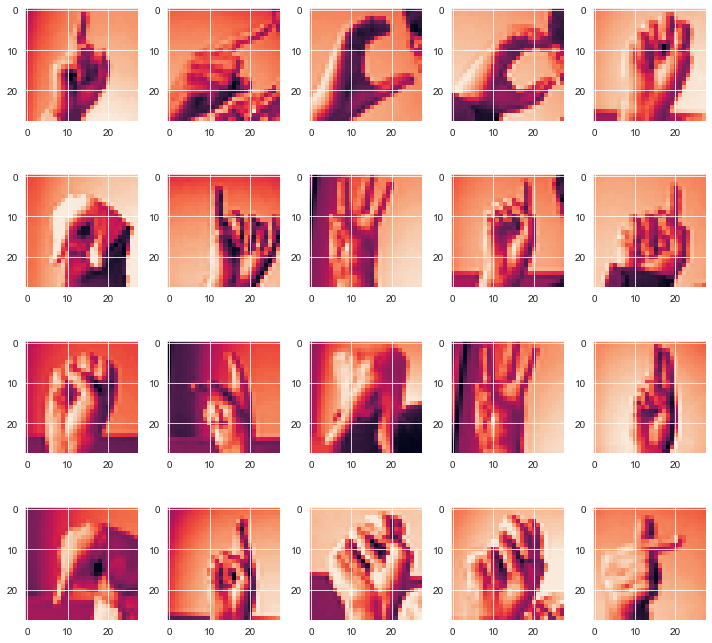

In [11]:
f, ax = plt.subplots(4,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28, 28))
        k += 1
    plt.tight_layout()  

In [12]:
len(X_train)

27455

In [102]:
# data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center = False,  
        samplewise_center = False,  
        featurewise_std_normalization = False,   
        samplewise_std_normalization = False,   
        zca_whitening = False,  
        rotation_range = 20,  
        zoom_range = 0.3,
        width_shift_range = 0.1, 
        height_shift_range = 0.1, 
        horizontal_flip = False,  
        vertical_flip = False)  

datagen.fit(X_train)

In [103]:
filename = "new_image_data.csv"
new_data = [] #store new images
new_label = [] #store the lable of new images

In [104]:
def write_to_csv(original_data, label, filename):
    for i in range(0, len(original_data)):
        pre_process = original_data[i].reshape((28*28,1))
        single_pic = []
        single_pic.append(label[0][i])
        for j in range(0,len(pre_process)):
            temp_pix = pre_process[j][0]
            single_pic.append(temp_pix)
        with open(filename,"a") as f:
            f_csv = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            f_csv.writerow(single_pic)

In [105]:
number_of_batches = 100
batches = 0

for X_batch, Y_batch in datagen.flow(X_train, y_train, batch_size=10):
    new_data.append(X_batch)
    new_label.append(Y_batch) 
#         loss = model.train(X_batch, Y_batch)
    batches += 1
    if batches >= number_of_batches:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

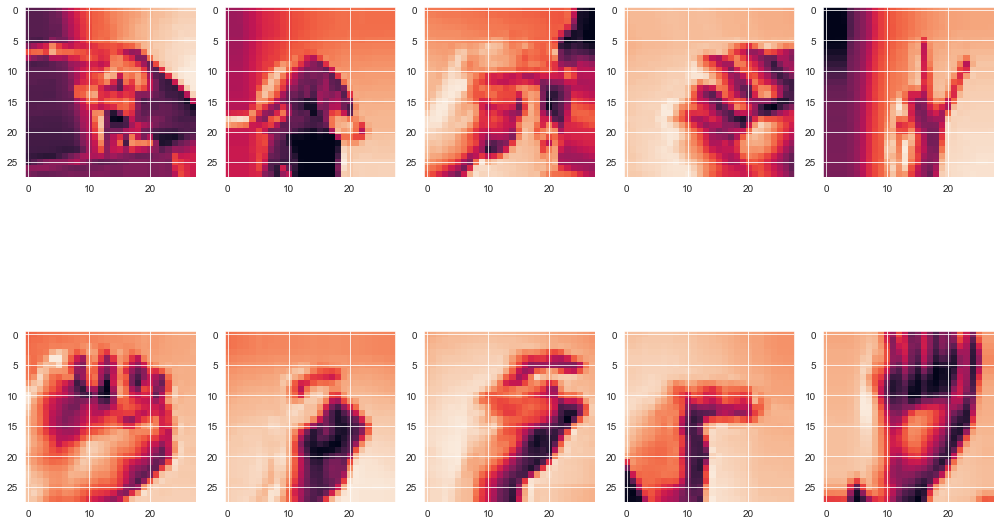

In [106]:
##### from matplotlib import pyplot
#show the new images
f, ax = plt.subplots(2,5) 
f.set_size_inches(14, 14)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(new_data[1][k].reshape(28, 28))
        k += 1
    plt.tight_layout()  

In [108]:
len(new_data)

100

In [109]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(25, activation = 'softmax'))

In [110]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

In [111]:
batch_size = 128
history = model.fit(datagen.flow(X_train, y_train_cat, batch_size = batch_size), epochs = 30,
                    validation_data = (X_test, y_test_cat))

Epoch 1/30
215/215 [==============================] - 19s 86ms/step - loss: 2.9413 - accuracy: 0.1103 - val_loss: 2.3087 - val_accuracy: 0.2585
Epoch 2/30
215/215 [==============================] - 17s 80ms/step - loss: 2.1216 - accuracy: 0.3169 - val_loss: 1.4694 - val_accuracy: 0.5231
Epoch 3/30
215/215 [==============================] - 17s 80ms/step - loss: 1.6685 - accuracy: 0.4520 - val_loss: 1.0214 - val_accuracy: 0.6652
Epoch 4/30
215/215 [==============================] - 18s 84ms/step - loss: 1.4219 - accuracy: 0.5254 - val_loss: 0.7774 - val_accuracy: 0.7528
Epoch 5/30
215/215 [==============================] - 18s 81ms/step - loss: 1.2566 - accuracy: 0.5750 - val_loss: 0.5947 - val_accuracy: 0.8187
Epoch 6/30
215/215 [==============================] - 17s 80ms/step - loss: 1.1127 - accuracy: 0.6208 - val_loss: 0.5849 - val_accuracy: 0.7791
Epoch 7/30
215/215 [==============================] - 17s 79ms/step - loss: 1.0096 - accuracy: 0.6559 - val_loss: 0.4535 - val_accuracy:

In [ ]:
def getLetter(number):
    signLabels = {0:'A',
                   1:'B',
                   2:'C',
                   3:'D',
                   4:'E',
                   5:'F',
                   6:'G',
                   7:'H',
                   8:'I',
                   9:'J',
                   10:'K',
                   11:'L',
                   12:'M',
                   13:'N',
                   14:'O',
                   15:'P',
                   16:'Q',
                   17:'R',
                   18:'S',
                   19:'T',
                   20:'U',
                   21:'V',
                   22:'W',
                   23:'X',
                   24:'Y' }
    try:
        return signLabels[int(number)]
    except:
        return 'Error'

In [ ]:
import math
import time
from cvzone.HandTrackingModule import HandDetector
import cv2

In [ ]:
cap = cv2.VideoCapture(0) #0 is id number for webcam
detector = HandDetector(maxHands = 1)


offset = 20
imgSize = 300
#counter = 0


while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, width, height = hand['bbox']
        
        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8)*255 #0..255
        imgCrop = img[y-offset:y+height+offset, x-offset:x+width+offset]
        
        imgCropShape = imgCrop.shape
        
        aspectRatio = height/width
        if aspectRatio > 1:
            k = imgSize/height
            widthCalc = math.ceil(k*width)
            imgResize = cv2.resize(imgCrop, (widthCalc, imgSize))
            imgResizeShape = imgResize.shape
            widthGap = math.ceil((imgSize - widthCalc)/2)
            imgWhite[:, widthGap:widthCalc+widthGap] = imgResize   
        else:
            
            k = imgSize/width
            heightCalc = math.ceil(k*height)
            imgResize = cv2.resize(imgCrop, (imgSize, heightCalc))
            imgResizeShape = imgResize.shape
            heightGap = math.ceil((imgSize - heightCalc)/2)
            try:
                imgWhite[heightGap:heightCalc+heightGap, :] = imgResize

            except cv2.error as e:
                print("put your hand farther from the camera")
                continue
        #print('imgWhite',imgWhite)
        #print('imgCrop',imgCrop)
        #cv2.imshow('ImageCrop', imgCrop)
       # cv2.imshow('imgWhite', imgWhite)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    
        #cv2.imshow('roi', roi)
    # convert an image from one color space to another (to GRAY)
        imgWhite = cv2.cvtColor(imgWhite, cv2.COLOR_BGR2GRAY) 
        imgWhite = cv2.resize(imgWhite, (28, 28), interpolation = cv2.INTER_AREA)
    
        cv2.imshow('roi scaled and grey', imgWhite)
    #
        #copy = img.copy()
        #cv2.rectangle(copy,(320,100), (620,400), (255,0,0), 5)
        #print('roi', roi.shape)
        imgWhite = imgWhite.reshape(1, 28,28,1)
    
        predict_x=model.predict(imgWhite)
        pred_number=np.argmax(predict_x, axis=1)
        cv2.putText(img, getLetter(pred_number),(x-offset, y-offset), cv2.FONT_HERSHEY_COMPLEX, 2, (0,255,0), 2)
    
        cv2.imshow('frame', img)
    
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #        break
        if cv2.waitKey(1) == 13:
            break
cap.release()
cv2.destroyAllWindows()